In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal as mnormal
from scipy.stats import invwishart, wishart
from scipy.special import logsumexp


# Start by loading the Old Faithful dataset

You can find it at https://www.kaggle.com/datasets/janithwanni/old-faithful
    
Save as 'faithful.csv'

In [2]:
df = pd.read_csv('faithful.csv')
del df['Unnamed: 0']
df.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


## Let's take a look at what the data looks like

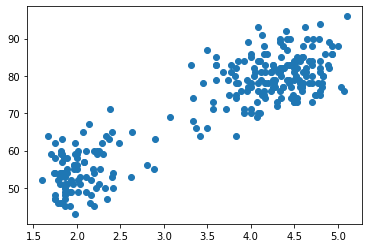

In [3]:
plt.scatter(df['eruptions'], df['waiting'])
plt.show()

## To make it easier when we come to specify priors, let's standardize

In [4]:
data = df.to_numpy() # I don't like working with dataframes!
data_standardized = data - np.expand_dims(np.mean(data, 0), 0)
data_standardized = data_standardized / np.expand_dims(np.std(data, 0), 0)


Let's start by implementing the EM algorithm.

Let $K$ be the number of clusters; $\gamma_{ic}$ be the "responsibility" of cluster $c$ for observation $i$; and $\pi_c$ be the cluster probability (which we assume fixed... how can we change that to be learned?).

Let $\mu_c$ and $\Sigma_c$ be the mean and covariance of the $c$th cluster, respectively

The E-step calculates the responsibilities, given the means and covariances:

$$\gamma_{ic} = \frac{\pi_c N(x_i \ | \ \mu_c,\Sigma_c)}{\sum_{k=1}^K \pi_k N(x_i \ | \ \mu_k,\Sigma_k)}$$ where $N(\boldsymbol{x} \ | \ \boldsymbol{\mu},\boldsymbol{\Sigma})$ describes the mulitvariate Gaussian with:

The M-step calculates the mean and covariance that maximize the overall likelihood, given the responsibilities. In this case, this is just the weighted mean and covariance

$$\mu_c = \frac{\sum_{i=1}^N \gamma_{i,c}x_i}{\sum_{i=1}^N \gamma_{i,c}} \qquad \qquad \Sigma_c = \frac{\sum_{i=1}^N \gamma_{i,c} (x_i-\mu_c) (x_i-\mu_c)^T}{\sum_{i=1}^N\gamma_{i,c}}$$

In [5]:

# EM algorithm

def initialize_cluster_means(data, num_clusters, fixed_cov=None):
    # initialize the clusters, vaguely centered on the data
    N, D = data.shape
    means = {}
    covs = {}
    data_mean = np.mean(data, 0)
    data_cov = np.cov(data.T)
    for cluster in range(num_clusters):
        means[cluster] = np.random.multivariate_normal(data_mean, data_cov)
        if fixed_cov is None:
            covs[cluster] = invwishart.rvs(df=D+1, scale=data_cov)
        else:
            covs[cluster] = fixed_cov
    return means, covs

def EM_algorithm(data, num_clusters, pie=None, num_iters=100, fixed_cov=None):
    # can input a fixed covariance matrix in fixed_cov
    N, D = data.shape
    
    # if unspecified, assume fixed, uniform probabilities (can you change this to be learnable?)
    if pie is None:
        pie = np.ones(num_clusters)/num_clusters
    else:
        assert len(pie) == num_clusters
        assert np.sum(pie) == 1
        
    # initialize the clusters, vaguely centered on the data
    means, covs = initialize_cluster_means(data, num_clusters, fixed_cov)
    
    log_likelihoods = []
    
    for i in range(num_iters):
        # E step
        # calculate expected labels, given means and covariances
        log_gammas = np.zeros((N, num_clusters)) # I am working in log probabilities to avoid overflow issues
        for cluster in range(num_clusters):
            log_gammas[:, cluster] = mnormal.logpdf(data, means[cluster], covs[cluster]) + np.log(pie[cluster])

        # normalize responsibilities in log space
        ll = logsumexp(log_gammas, 1)
        log_gammas = log_gammas - np.expand_dims(ll, 1)
        # logsumexp is a super useful function if you haven't used it before!!
        gammas = np.exp(log_gammas)
        log_likelihoods.append(np.mean(ll))
        assert np.all(np.isfinite(gammas)) # just in case! But working in log space should have avoided this
        
        # M step
        cluster_gamma_totals = np.sum(gammas, 0)

        for cluster in range(num_clusters):
            means[cluster] = np.dot(gammas[:, cluster], data) / cluster_gamma_totals[cluster]
            centered_data = data - np.expand_dims(means[cluster], 0) # x-mu
            if fixed_cov is None:
                covs[cluster] = np.dot(centered_data.T, np.expand_dims(gammas[:, cluster], 1) * centered_data) 
                covs[cluster] /= cluster_gamma_totals[cluster]
          
    return means, covs, gammas, log_likelihoods

def plot_clusters(data, probs, dims=[0,1]):
    hard_assignments = np.argmax(probs, 1) # get the most likely cluster
    num_clusters = probs.shape[1]
    for cluster in range(num_clusters):
        plt.scatter(data[hard_assignments==cluster, dims[0]], data[hard_assignments==cluster, dims[1]])
        
    plt.show()

## You can either run with fixed covariance...

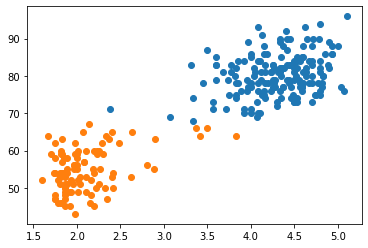

In [6]:
means, covs, gammas, log_likelihoods = EM_algorithm(data, 2, fixed_cov=np.eye(2))
plot_clusters(data, gammas)

## Or learn the covariance

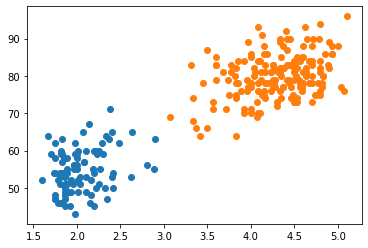

In [7]:
means, covs, gammas, log_likelihoods = EM_algorithm(data, 2)
plot_clusters(data, gammas)

## Here, the number of clusters seems clear, but we can vary it if we want

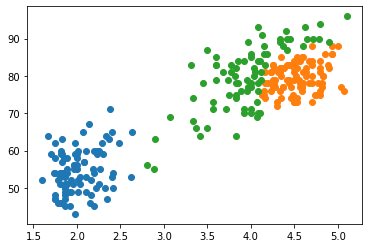

In [8]:
means, covs, gammas, log_likelihoods = EM_algorithm(data, 3)
plot_clusters(data, gammas)

# We can plot the log likelihood over time to see how we are doing

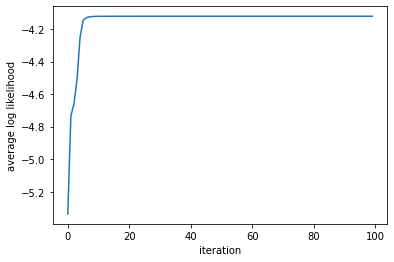

In [11]:
plt.plot(log_likelihoods)
plt.xlabel('iteration')
plt.ylabel('average log likelihood')
plt.show()

# Now let's do VBayes!

We went through the derivation for 1d data with unit variance in the paper...

Let's see if you can expand to 2d data!

Let's start by assuming fixed spherical covariances, so that:

$$\begin{aligned}
\mu_i \sim& N(\mu_0, \sigma_0^2 I)\\
z_i \sim& \pi\\
x_i \sim& N(\mu_{z_i}, \sigma_x^2 I)
\end{aligned}$$




Let's start by writing out the terms of the log joint:

$$
\log p(x, \{z_i\}, \{mu_c\}) = \sum_i \left(\log p(x_i | z_i, \{mu_c\}, \sigma_x^2) + \log p(z_i | \pi) \right)+ \sum_c \left(\log p(\mu_c | \mu_0, \sigma_0^2) \right)$$

Fill in the individual terms below:

$$\begin{aligned}
\log p(x_i | z_i, \{\mu_c\}, \sigma_x^2) =& \\
\log p(z_i | \pi) =& \\
\log p(\mu_c | \mu_0, \sigma_0^2) =& 
\end{aligned}$$


## Calculating the updates

We know $q^*(z_i) \propto \exp\left\{\mathbb{E}\left[\log p(z_i, \{x_i\}, \{z_j: j\neq i\}, \{\mu_c\})\right]\right\}$, where the expectation is taken wrt q of all the other variables.

We know that most of the terms are constant wrt $z_i$, allowing us to write:

 $$q^*(z_i) \propto \exp\left\{\mathbb{E}\left[\log p(x_i | z_i, \{\mu_c\}, \sigma_x^2) + \log p(z_i|pi)\right]\right\} = \exp\left\{z_i^T\log \pi_{z_i} + \mathbb{E}\left[\log p(x_i | z_i, \{\mu_c\}, \sigma_x^2)\right]\right\}$$
 
Here, I am assuming $z_i$ is a length-$K$ vector. Note we can take the $\log p(z_i|\pi)$ out of the expectation, since it isn't affected by any of our variational distributions

Based on your derivations above, fill in the following:

$$q^*(z_i) \propto \exp \left\{ \right\}$$

What distribution does that imply?? (If it doesn't look like a standard distribution, you've probably maede a mistake somewhere!)



(should look similar to what we saw in the paper, but now we have $\pi$ not necessarily symmetric, and multivariate $\mu$)


We know $q^*(\mu_c) \propto \exp\left\{\mathbb{E}\left[\log p(\mu_c, \{x_i, z_i\}, \{z_j: j\neq c\}\right]\right\}$, where the expectation is taken wrt q of all the other variables.

This gives us... (fill in)

 $$q^*(\mu_c) \propto \exp\left\{\right\}$$
 
What distribution does that imply for the $\mu_c$? (again, should be fairly similar to what we saw in the paper)

## Spoilers!!

OK, I'm going to assume you have something that you can write in the form:

$$q^*(z_i) = \text{Categorical}(\gamma_i) \qquad \qquad q^*(\mu_c) = N(m_c, s_c^2 I)$$


Now that we know the form of $q$, we can write out the whole ELBO (go ahead and fill it out below:

$$ELBO = $$


## OK let's write some code!!

I've made a template below, fill in where it says "TODO"

In [ ]:
def VBayes_1(data, num_clusters=2, pie=None, mu0=[0., 0.], sig2_0=1., sig2_x=1., num_iters=100):

    N, D = data.shape
    
    if pie is None:
        pie = np.ones(num_clusters)/num_clusters
    else:
        assert len(pie) == num_clusters
        assert np.sum(pie) == 1
    
    # some initializations
    m = {} 
    s2 = {} 
    for cluster in range(num_clusters):
        m[cluster] = np.random.normal(mu0, sig2_0)
        s2[cluster] = np.random.rand()
        
    gammas = np.random.rand(N, num_clusters)
    gammas = gammas / np.expand_dims(np.sum(gammas, 1), 1)
    
    
    elbo = [] # 
    for i in range(num_iters):
        # update the parameters of q(z) (peek at the E step for the EM algo if you get stuck implementing)
        
        gammas = TODO
        
        # update the parameters of q(\mu_c) (peek at the M-step for the EM algo if you get stuck implementing)
        for cluster in range(num_clusters):
            m[cluster] = TODO
            s2[cluster] = TODO
            
        # calculate the ELBO for tracking
        
        current_elbo = 
        elbo.append(TODO)
        
          
    return m, s2, gammas, elbo

# You can check it out on the data we used for the EM!

* How does it compare with the EM output?
* Try different priors: How do the choice of priors impact the outcome?

In [ ]:
means, covs, gammas, elbos = VBayes_1(data_standardized, mu0=[0., 0.], sig2_0=1., sig2_x=1.)
plot_clusters(data, gammas)

In [ ]:
means, covs, gammas, elbos = VBayes_1_complete(data_standardized, mu0=[0., 0.], sig2_0=1., sig2_x=1.)

## Sanity check -- is the ELBO going up over time?

In [ ]:
plt.plot(log_likelihoods)
plt.xlabel('iteration')
plt.ylabel('average log likelihood')
plt.show()

## Let's look at a more complicated model!

Let's try using a normal-Wishart prior on the means and precision matrices:

$$p(\mu_c, \Lambda_c) = NW(\mu_c, \Lambda_c|\mu_0, \beta, W,  \nu) = N\left(\mu_c| \mu_0, (\beta\Lambda_c)^{-1}\right)\text{Wishart}(\Lambda_c|W, \nu)$$

And a Dirichlet($\alpha, \dots, \alpha)$ prior for $\pi$


To complete our generative model, we have:

$$z_i \sim \pi \qquad \qquad x_i \sim N(\mu_{z_i}, \Lambda_{z_i}^{-1})$$

Let's start by writing out the terms of the log joint:

$$
\log p(x, \{z_i\}, \{mu_c, \Lambda_c\}, \pi) = \log p(x | \{z_i\}, \{mu_c, \Lambda_c\}, \pi) + \sum_i \left(\log p(z_i | \pi) \right)+ \sum_c \left(\log p(\mu_c | \mu_0, \beta, \Lambda_c) + \log p(\Lambda_c |W, \nu)\right) + \log p(\pi)$$


Fill in the individual terms below:

$$\begin{aligned}
\log p(x | \{z_i\}, \{mu_c, \Lambda_c\}, \pi) =& \\
\log p(z_i | \pi)  =& \\
\log p(\mu_c | \mu_0, \beta, \Lambda_c) =& \\
\log p(\Lambda_c |W, \nu) =& \\
\log p(\pi) =&\end{aligned}$$


## Calculating the updates:

We are going to use an approximation of the form $q(\{z_i\}, \{\mu_k, \Lambda_k\}) = \prod_i q(z_i)\prod_k q(\mu_k,\Lambda_k)$



### $q^*(z_i)$
This is going to be pretty similar to before! Except, we now need to take the expectation of $p(z_i|\pi)$ wrt $q(\pi)$

So we have:

 $$q^*(z_i) \propto \exp\left\{\mathbb{E}_{\{q(\mu_c, \Lambda_c)\}}\left[\log p(x_i | z_i, \{\mu_c\}, \{\Lambda_c\})\right] + \mathbb{E}_{q(\pi)}\left[\log p(z_i|pi)\right]\right\}$$
 
 You should be able to write this out as a function of $\mathbb{E}_{\{q(\mu_c, \Lambda_c)\}}\left[\log | \Lambda_c |\right]$, $\mathbb{E}_{q(\mu_c, \Lambda_c)}\left[(x-\mu_c)^T\Lambda_c(x-\mu_c)\right]$ and $\mathbb{E}_{q(\pi)}\log \pi$...
 
  $$q^*(z_i) \propto TODO$$
  
  As before, it should look like a Categorical($\gamma_i$), for some $\gamma_i$! We can't yet calculate $\mathbb{E}_{\{q(\mu_c, \Lambda_c)\}}\left[\log | \Lambda_c |\right]$ and $\mathbb{E}_{q(\pi)}\log \pi$ until we know the appropriate forms of $q$...
 

### $q^*(\pi)$

We have:

 $$\begin{aligned}
 q^*(\pi) \propto& \exp\left\{\mathbb{E}_{\{q(z_i)\}}\left[\sum_i\log p(z_i|\pi) + \log p(\pi)\right]\right\}\\
 \propto& TODO
 \end{aligned}$$
 
 We can write this out fully in terms of the $\gamma_i$ we used above, since we know $q(z_i)=\text{Categorical}(\gamma_i)$. It should look like a Dirichlet($\tau$), for some $\tau$!
 
 ### $q^*(\mu_c, \Lambda_c)$
 
  $$q^*(\mu_c, \Lambda_c) \propto \exp\left\{\mathbb{E}_{\{q(z_i)\}}\left[\log p(x_i | z_i, \{\mu_c\}, \{\Lambda_c\})\right] + \log p(\mu_c, \Lambda_c)\right\}$$
 

Bit of a longer sum, but we can do it!

$$q^*(\mu_c) \propto TODO$$

You're probably guessing that this is going to correspond to a normal-Wishart($\mu_c, \Lambda_c|m_c, \beta_c, W_c,  \nu_c)$  distribution, and you'd be right. What are the parameters of this distribution?



## Finish off by adding in $\mathbb{E}_{\{q(\mu_c, \Lambda_c)\}}\left[\log | \Lambda_c |\right]$ and $\mathbb{E}_{q(\pi)}\left[\log \pi\right]$

You've done a lot of math, so here's the results you need:

* If $x\sim \text{Dirichlet}(\alpha)$, then $\mathbb{E}[\log(x_k)] = \psi(\alpha_k) - \psi(\sum_j\alpha_j)$, where $\psi$ is the digamma function 
* If $\Lambda \sim \text{Wishart}(W, \nu)$ where $W$ is $D\times D$, then $\mathbb{E}\left[\log |\Lambda|\right] = \psi_D\left(\frac{\nu}{2}\right) + D\log(2) + \log |W|$, where $\psi_D$ is a multivariate digamma function

## Now let's code it up!


In [ ]:
def VBayes_2(data, num_clusters=2, alpha=1., mu0=[0., 0.], beta=1., nu=3, W=np.eye(2), num_iters=100):
    # assuming symmetric dirichlet prior, alpha_k = alpha for all k
    N, D = data.shape
   
    
    # some initializations
    
    tau = np.ones(num_clusters)
    gammas = np.random.rand(N, num_clusters)
    gammas = gammas / np.expand_dims(np.sum(gammas, 1), 1)
    
    m_c = {} 
    beta_c = {}
    W_c = {}
    nu_c = {}
    for cluster in range(num_clusters):
        nu_c[cluster] = nu
        W_c[cluster] = wishart.rvs(nu, W)
        beta_c[cluster] = 1.
        m_c[cluster] = np.random.multivariate_normal(mu0, W_c[cluster])

    elbo = [] # 
    for i in range(num_iters):
        # 
        
        gammas = TODO
        
        tau = TODO
        
        for cluster in range(num_clusters):
            beta_c[cluster] = TODO
            m_c[cluster] = TODO
            nu_c[cluster] = TODO
            W_c[cluster] = TODO
        
        
        elbo.append(TODO)
        
          
    return gammas, tau, m_c, beta_c, W_c, nu_c, elbo

In [ ]:
gammas, tau, m_c, beta_c, W_c, nu_c, elbo = VBayes_2(data_standardized, num_clusters=2, alpha=1., mu0=[0., 0.], beta=1., nu=3, W=np.eye(2))
plot_clusters(data, gammas)